# Programmentwurf Data Science
#### Ilvy Schulz und Pia Skuthan

In [3]:
# Alle Importe der Datei - bitte zum Anfang einmal ausführen
import scipy.io
import matplotlib.pyplot as plt

## 1. Data Understanding

Zuerst werden die Daten aus der Datei eingelesen und anschließend wird die Form überprüft.
So kann sicher gestellt werden, dass die Daten richtig eingelesen werden und, wie vorgegeben, die Form (128, 128 191) besitzt.

In [ ]:
ims_cube = scipy.io.loadmat("ims_cube.mat")["ims_cube"]
ims_cube.shape

(128, 128, 191)

Um die räumliche Verteilung einzelner Features des Datensatzes zu untersuchen, werden exemplarisch acht Kanäle aus dem Spektralbereich ausgewählt.
Da die Daten 191 spektrale Kanäle (0–190) umfassen, werden die Features in 25er-Schritten gewählt, um eine gleichmäßige Verteilung über das gesamte Spektrum zu erhalten und verschiedene Bereiche der Daten zu betrachten.

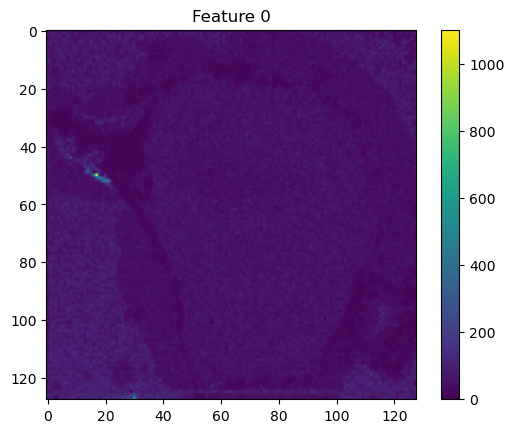

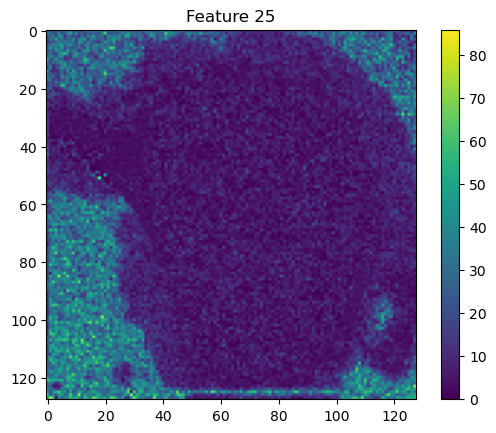

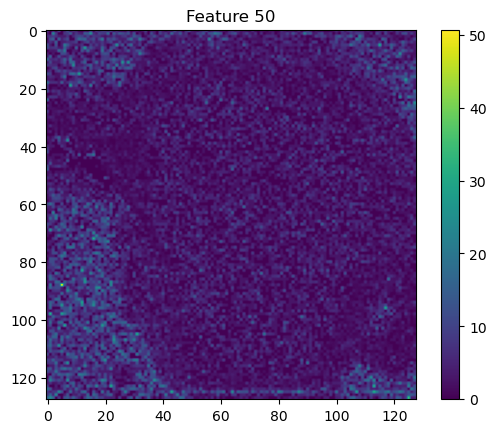

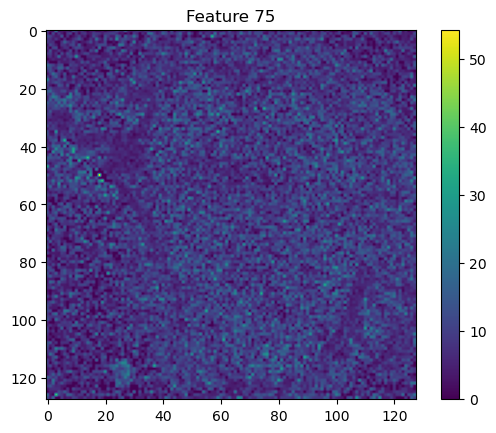

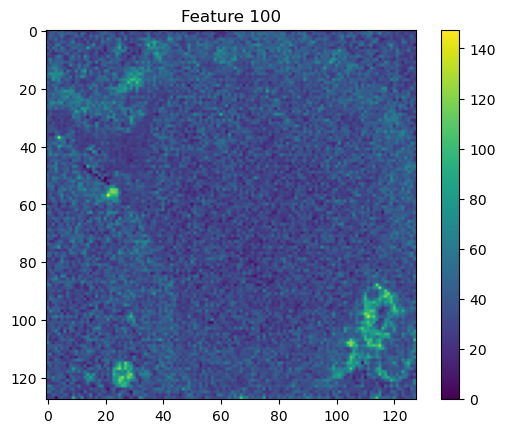

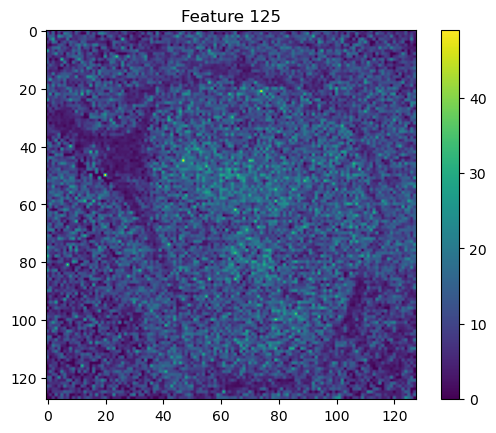

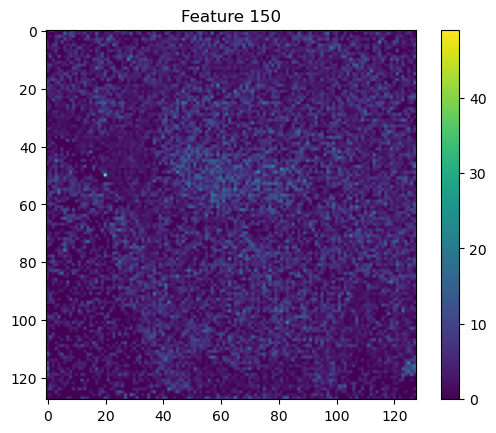

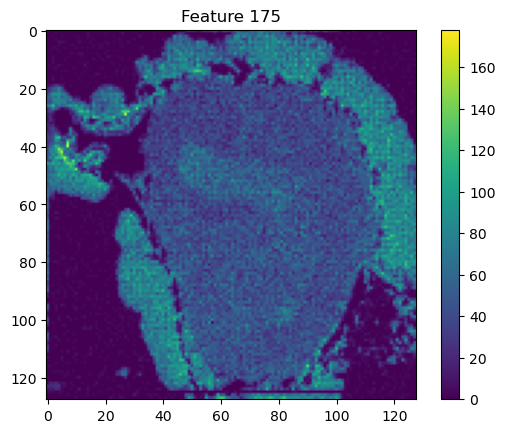

In [ ]:
for i in range(0,190,25):
    plt.imshow(ims_cube[:, :, i])
    plt.title(f"Feature {i}")
    plt.colorbar()
    plt.show()